# Инициализация токенизатора

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset

def define_model(path_to_model):
    tokenizer = AutoTokenizer.from_pretrained(path_to_model)
    model = AutoModelForCausalLM.from_pretrained(path_to_model,
                                                 torch_dtype="auto",
                                                 device_map="auto")
    return tokenizer, model

teacher_tokenizer, teacher_model = define_model('./teacher_model/')

/Users/mikhail/Desktop/Distillation/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]
The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


# Подсчет числа правильных ответов GSM8K

In [2]:
str_to_delete = '''prompt="\nProblem:\nOlivia has $23. She bought five cupcakes for $3 each and a milkshake for $4. How much money does she have left?\nSolution:\nFirst, calculate the total cost of the cupcakes:\n5 cupcakes × $3 = $15.\nAdd the cost of the milkshake: $15 + $4 = $19.\nSubtract from her initial amount: $23 − $19 = $4.\nSo, Olivia has $4 left.\nFinal Answer: 4\u200b\n\nProblem:\nA bakery sells cookies in packs of 6. If a customer buys 9 packs, how many cookies does the customer get in total?\nSolution:\nEach pack contains 6 cookies.\nThe customer buys 9 packs.\nTotal cookies = 6 × 9 = 54.\nFinal Answer: 54\n\nProblem:\nThere are 42 students in a class. One-third of them are boys. How many girls are in the class?\nSolution:\nNumber of boys = 42 ÷ 3 = 14.\nNumber of girls = total students − boys = 42 − 14 = 28.\nFinal Answer: 28\n\nProblem:\nA car travels 60 miles per hour. How many miles does it travel in 2 hours and 30 minutes?\nSolution:\nConvert 2 hours 30 minutes to hours: 2.5 hours.\nDistance = speed × time = 60 × 2.5 = 150 miles.\nFinal Answer: 150\n\nProblem:\nJames has 3 times as many marbles as Lisa. Together, they have 48 marbles. How many marbles does James have?\n\nSolution:\nLet Lisa have x marbles.\nThen James has 3x marbles.\nTogether: x + 3x = 4x = 48.\nSo, x = 48 ÷ 4 = 12.\nJames has 3 × 12 = 36 marbles.\nFinal Answer: 36\n\nJanet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?'''

student_score = []
teacher_score = []

import glob
import re
txt_arr = []

txt_arr = glob.glob("./ft_student_outputs/*.txt")

# for filename in glob.glob("*_nt_16.txt"):
#     if '_nt' in filename:
#         txt_arr.append(filename)

# print()
mean_len_all_files_student = []
mean_len_all_files_teacher = []

for txt in txt_arr:
    print(f'{txt=}')
    with open(f'{txt}', 'r', encoding='utf-8') as f:
        data = f.read()
    if str_to_delete in data:
        data = data.replace(str_to_delete, '')
    splitted = data.split(f'-----'*20)
    # print(splitted)

    comparison_dict = {'student_score': 0,
                       'teacher_score': 0}

    lens_per_file_student = []
    lens_per_file_teacher = []

    for task in splitted:
        # Correct answer
        correct_answer = task[task.find('Correct answer: ')+len('Correct answer: '):task.find('\n\nStudent solution')]
        correct_answer = correct_answer.replace(',', '').replace('.', '')
        
        student_solution = task[task.find('Student solution: ')+len('Student solution: '):task.find('Teacher solution:')]
        teacher_solution = task[task.find('Teacher solution: ')+len('Teacher solution: '):task.find('----------------------------------------------------------------------------------------------------')]
        
        len_of_student_solution = len(teacher_tokenizer.encode(student_solution, add_special_tokens=False))
        lens_per_file_student.append(len_of_student_solution)

        len_of_teacher_solution = len(teacher_tokenizer.encode(teacher_solution, add_special_tokens=False))
        lens_per_file_teacher.append(len_of_teacher_solution)

        # Student parsed answer
        idx = task.find('\n\nTeacher solution')
        if idx == -1:
            student_answer = task[-50:]
        else:
            start = max(0, idx - 50)
            student_answer = task[start:idx]

        student_answer = student_answer.replace(',', '').replace('.', '')

        # Teacher parsed answer
        teacher_answer = task[-50:].replace(',', '').replace('.', '')

        student_answer = re.findall(r'-?\b\d+\b', student_answer)
        teacher_answer = re.findall(r'-?\b\d+\b', teacher_answer)
        
        # print(f"{correct_answer=}")
        # print(f"{student_answer=}")
        # print(f"{teacher_answer=}")

        if correct_answer in student_answer:
            comparison_dict['student_score'] += 1
        if correct_answer in teacher_answer:
            comparison_dict['teacher_score'] += 1
        
        # print('---------------------------------')

    mean_per_file_student = sum(lens_per_file_student)/len(lens_per_file_student)
    mean_per_file_teacher = sum(lens_per_file_teacher)/len(lens_per_file_teacher)
    print(f'{mean_per_file_student=}')
    print(f'{mean_per_file_teacher=}')
    mean_len_all_files_student.append(mean_per_file_student)
    mean_len_all_files_teacher.append(mean_per_file_teacher)
    print(f'{comparison_dict=}')
    student_score.append(comparison_dict['student_score'])
    teacher_score.append(comparison_dict['teacher_score'])
    print('---------------------------------')

print(f'Среднее значений по всем файлам (ученик): {sum(mean_len_all_files_student)/len(mean_len_all_files_student)}')
print(f'Среднее значений по всем файлам (учитель): {sum(mean_len_all_files_teacher)/len(mean_len_all_files_teacher)}')

txt='./ft_student_outputs/3_ft.txt'
mean_per_file_student=209.50996015936255
mean_per_file_teacher=216.65338645418328
comparison_dict={'student_score': 144, 'teacher_score': 144}
---------------------------------
txt='./ft_student_outputs/14_ft.txt'
mean_per_file_student=203.61354581673308
mean_per_file_teacher=210.76892430278883
comparison_dict={'student_score': 144, 'teacher_score': 144}
---------------------------------
txt='./ft_student_outputs/1_ft.txt'
mean_per_file_student=206.04347826086956
mean_per_file_teacher=212.28458498023716
comparison_dict={'student_score': 151, 'teacher_score': 151}
---------------------------------
txt='./ft_student_outputs/10_ft.txt'
mean_per_file_student=201.9442231075697
mean_per_file_teacher=209.09163346613545
comparison_dict={'student_score': 148, 'teacher_score': 148}
---------------------------------
txt='./ft_student_outputs/9_ft.txt'
mean_per_file_student=206.28286852589642
mean_per_file_teacher=213.43426294820716
comparison_dict={'student_sco

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# fig, ax = plt.subplots()
launches = list(range(1,11))
means_student = mean_len_all_files_student[1:11]
means_teacher = mean_len_all_files_teacher[1:11]


# ax.bar(launches, means)
# ax.set_ylabel('Длина ответа (в токенах)')
# ax.set_title('Подсчет длины ответа в задаче GSM8K')
# # ax.legend(title='Fruit color')

# plt.show()

print(f'Ученик токены: {means_student}')
print(f'Учитель токены: {means_teacher}')

print(f'СКО ученика токены: {np.std(means_student)}')
print(f'СКО учителя токены: {np.std(means_teacher)}')
print('###########################################################')
student_score = student_score[:10]
teacher_score = teacher_score[:10]

print(f'Ученик доля решенных задач: {[elem/250 for elem in student_score]}')
print(f'Учитель доля решенных задач: {[elem/250 for elem in teacher_score]}')

print(f'Ученик среднее число правильных решений: {np.mean([elem/250 for elem in student_score])}')
print(f'Учитель среднее число правильных решений: {np.mean([elem/250 for elem in teacher_score])}')

print(f'СКО ученика по правильным решениям: {np.std([elem/250 for elem in student_score])}')
print(f'СКО учителя по правильным решениям: {np.std([elem/250 for elem in teacher_score])}')

Ученик токены: [203.61354581673308, 206.04347826086956, 201.9442231075697, 206.28286852589642, 207.09163346613545, 211.61354581673308, 202.14342629482073, 206.8207171314741, 203.6414342629482, 205.78486055776892]
Учитель токены: [210.76892430278883, 212.28458498023716, 209.09163346613545, 213.43426294820716, 214.23505976095618, 218.75298804780877, 209.29880478087648, 213.9840637450199, 210.79282868525897, 212.9243027888446]
СКО ученика токены: 2.71229610899757
СКО учителя токены: 2.704727171499174
###########################################################
Ученик доля решенных задач: [0.576, 0.576, 0.604, 0.592, 0.556, 0.588, 0.568, 0.616, 0.576, 0.624]
Учитель доля решенных задач: [0.576, 0.576, 0.604, 0.592, 0.556, 0.588, 0.568, 0.616, 0.576, 0.624]
Ученик среднее число правильных решений: 0.5875999999999999
Учитель среднее число правильных решений: 0.5875999999999999
СКО ученика по правильным решениям: 0.020509509989270834
СКО учителя по правильным решениям: 0.020509509989270834


# Подсчет числа правильных ответов CSQA

In [7]:
str_to_delete = '''prompt="\nProblem:\nOlivia has $23. She bought five cupcakes for $3 each and a milkshake for $4. How much money does she have left?\nSolution:\nFirst, calculate the total cost of the cupcakes:\n5 cupcakes × $3 = $15.\nAdd the cost of the milkshake: $15 + $4 = $19.\nSubtract from her initial amount: $23 − $19 = $4.\nSo, Olivia has $4 left.\nFinal Answer: 4\u200b\n\nProblem:\nA bakery sells cookies in packs of 6. If a customer buys 9 packs, how many cookies does the customer get in total?\nSolution:\nEach pack contains 6 cookies.\nThe customer buys 9 packs.\nTotal cookies = 6 × 9 = 54.\nFinal Answer: 54\n\nProblem:\nThere are 42 students in a class. One-third of them are boys. How many girls are in the class?\nSolution:\nNumber of boys = 42 ÷ 3 = 14.\nNumber of girls = total students − boys = 42 − 14 = 28.\nFinal Answer: 28\n\nProblem:\nA car travels 60 miles per hour. How many miles does it travel in 2 hours and 30 minutes?\nSolution:\nConvert 2 hours 30 minutes to hours: 2.5 hours.\nDistance = speed × time = 60 × 2.5 = 150 miles.\nFinal Answer: 150\n\nProblem:\nJames has 3 times as many marbles as Lisa. Together, they have 48 marbles. How many marbles does James have?\n\nSolution:\nLet Lisa have x marbles.\nThen James has 3x marbles.\nTogether: x + 3x = 4x = 48.\nSo, x = 48 ÷ 4 = 12.\nJames has 3 × 12 = 36 marbles.\nFinal Answer: 36\n\nJanet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?'''

student_score = []
teacher_score = []

import glob
import re
student_arr = []
teacher_arr = []

student_arr = glob.glob("./teacher_outputs_CSQA_pretrain/*_16.txt")
teacher_arr = glob.glob("./teacher_outputs_CSQA_pretrain/*_16.txt")


print(student_arr)

['./teacher_outputs_CSQA_pretrain/3_16.txt', './teacher_outputs_CSQA_pretrain/1_16.txt', './teacher_outputs_CSQA_pretrain/10_16.txt', './teacher_outputs_CSQA_pretrain/9_16.txt', './teacher_outputs_CSQA_pretrain/5_16.txt', './teacher_outputs_CSQA_pretrain/7_16.txt', './teacher_outputs_CSQA_pretrain/2_16.txt', './teacher_outputs_CSQA_pretrain/8_16.txt', './teacher_outputs_CSQA_pretrain/4_16.txt', './teacher_outputs_CSQA_pretrain/6_16.txt']


In [8]:
mean_len_all_files_student_CSQA = []

for txt in student_arr:
    print(f'{txt=}')
    with open(f'{txt}', 'r', encoding='utf-8') as f:
        data = f.read()
    if str_to_delete in data:
        data = data.replace(str_to_delete, '')
    splitted = data.split(f'-----'*20)
    comparison_dict = {'score': 0}
    lens_per_file_student = []
    for task in splitted:
        # Correct answer
        correct_answer = task[task.find('Correct answer: ')+len('Correct answer: '):task.find('\n\nStudent solution')]
        student_solution = task[task.find('Student solution: ')+len('Student solution: '):task.find('----------------------------------------------------------------------------------------------------')]
        # print(f'{student_solution=}')

        len_of_student_solution = len(teacher_tokenizer.encode(student_solution, add_special_tokens=False))
        lens_per_file_student.append(len_of_student_solution)

        # Student parsed answer
        if 'is: **' in task:
            student_answer = task[task.find('is: **')+len('is: **'):task.find(' —')]
        elif 'is **' in task:
            student_answer = task[task.find('is **')+len('is **'):task.find(' —')]

        if correct_answer == student_answer:
            comparison_dict['score'] += 1

        # print('---------------------------------')
    mean_per_file_student = sum(lens_per_file_student)/len(lens_per_file_student)
    mean_len_all_files_student_CSQA.append(mean_per_file_student)
    print(f'{comparison_dict=}')
    student_score.append(comparison_dict['score'])
    print('---------------------------------')

print(f'Среднее значений по всем файлам (ученик): {sum(mean_len_all_files_student_CSQA)/len(mean_len_all_files_student_CSQA)}')

txt='./teacher_outputs_CSQA_pretrain/3_16.txt'
comparison_dict={'score': 49}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/1_16.txt'
comparison_dict={'score': 47}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/10_16.txt'
comparison_dict={'score': 49}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/9_16.txt'
comparison_dict={'score': 42}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/5_16.txt'
comparison_dict={'score': 45}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/7_16.txt'
comparison_dict={'score': 45}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/2_16.txt'
comparison_dict={'score': 44}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/8_16.txt'
comparison_dict={'score': 46}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/4_16.txt'
comparison_dict={'score': 43}
---------------------------------


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# fig, ax = plt.subplots()
launches = list(range(1,11))
means_student = mean_len_all_files_student_CSQA


# ax.bar(launches, means)
# ax.set_ylabel('Длина ответа (в токенах)')
# ax.set_title('Подсчет длины ответа в задаче GSM8K')
# # ax.legend(title='Fruit color')

# plt.show()

rounded = [int(elem) for elem in means_student]
for elem in rounded:
    print(elem)

print(f'Среднее ученика токены: {np.mean(rounded)}')
print(f'СКО ученика токены: {np.std(rounded)}')


167
173
167
191
174
176
182
177
181
178
Среднее ученика токены: 176.6
СКО ученика токены: 6.8


In [10]:
sum(student_score)/len(student_score)

45.8

In [11]:
mean_len_all_files_teacher_CSQA = []

for txt in teacher_arr:
    print(f'{txt=}')
    with open(f'{txt}', 'r', encoding='utf-8') as f:
        data = f.read()
    if str_to_delete in data:
        data = data.replace(str_to_delete, '')
    splitted = data.split(f'-----'*20)
    comparison_dict = {'score': 0}
    lens_per_file_teacher = []

    for task in splitted:
        # Correct answer
        correct_answer = task[task.find('Correct answer: ')+len('Correct answer: '):task.find('\n\nStudent solution')]
        teacher_solution = task[task.find('Student solution: ')+len('Student solution: '):task.find('----------------------------------------------------------------------------------------------------')]
        
        len_of_teacher_solution = len(teacher_tokenizer.encode(teacher_solution, add_special_tokens=False))
        lens_per_file_teacher.append(len_of_teacher_solution)
        
        lower_case = task.lower()
        # print(task)
        # Student parsed answer

        # Ищем шаблон вроде **A**, **B — text**, **C. something**
        import re

        # Извлекаем correct_answer как раньше (но аккуратно)
        # correct_part = task.split('Correct answer: ', 1)[-1].split('\n\nStudent solution')[0].strip()
        # correct_answer = correct_part.split()[0]  # Берём первую лексему: "A", "B", и т.д.

        # Для студента: ищем в конце Student solution последнюю строку с "answer"
        student_text = task.split('Student solution:', 1)[-1]

        # Ищем шаблоны типа:
        # - "Correct answer: A"
        # - "Final Answer: **B**"
        # - "So the best answer is: C"
        # - "Answer: D — ..."
        # - "✅ Correct Answer: E"

        patterns = [
            r'(?:correct|final|best)?\s*answer\s*[—:-]?\s*\*?([A-E])\*?',
            r'answer\s+is\s*:?\s*\*?([A-E])\*?',
            r'so the (?:best|correct) answer is\s*:?\s*\*?([A-E])',
            r'^\s*\*?([A-E])\s*—',
            r'\b([A-E])\s*—\s*[a-z]',
        ]

        student_answer = None
        for pattern in patterns:
            match = re.search(pattern, student_text, re.IGNORECASE | re.MULTILINE)
            if match:
                student_answer = match.group(1).lower()
                break

        # Если не нашли — пробуем найти последнюю заглавную букву A–E перед тире или в конце
        if student_answer is None:
            # Ищем все A-E в тексте и берём последнюю (часто работает)
            candidates = re.findall(r'\b([A-E])\b', student_text)
            if candidates:
                student_answer = candidates[-1].lower()

        # if student_answer is None:
        #     print("Не удалось распарсить ответ студента")
        # else:
        #     print(f"Извлечён ответ: {student_answer}")

        # if 'answer is: **' in lower_case:
        #     student_answer = lower_case[lower_case.find('answer is: **')+len('answer is: **'):lower_case.find(' —')]
        #     print(f'попали 1, распарсили {student_answer}')
        # elif 'answer: **' in lower_case:
        #     student_answer = lower_case[lower_case.find('answer: **')+len('answer: **'):lower_case.find(' —')]
        #     print(f'попали 2, распарсили {student_answer}')
        # elif 'answer is:\n\n**' in lower_case.lower():
        #     student_answer = lower_case[lower_case.find('answer is:\n\n**')+len('answer is:\n\n**'):lower_case.find(' —')]
        #     print(f'попали 3, распарсили {student_answer}')
        # elif 'answer is:\n**' in lower_case.lower():
        #     student_answer = lower_case[lower_case.find('answer is:\n**')+len('answer is:\n**'):lower_case.find(' —')]
        #     print(f'попали 4, распарсили {student_answer}')
        # elif 'answer : **' in lower_case.lower():
        #     student_answer = lower_case[lower_case.find('answer : **')+len('answer : **'):lower_case.find(' —')]
        #     print(f'попали 5, распарсили {student_answer}')

        if correct_answer.lower() == student_answer:
            comparison_dict['score'] += 1

        # print('---------------------------------')
    print(f'{comparison_dict=}')
    mean_per_file_teacher = sum(lens_per_file_teacher)/len(lens_per_file_teacher)
    mean_len_all_files_teacher_CSQA.append(mean_per_file_teacher)
    teacher_score.append(comparison_dict['score'])
    print('---------------------------------')

print(f'Среднее значение по всем файлам (учитель): {sum(mean_len_all_files_teacher_CSQA)/len(mean_len_all_files_teacher_CSQA)}')

txt='./teacher_outputs_CSQA_pretrain/3_16.txt'
comparison_dict={'score': 65}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/1_16.txt'
comparison_dict={'score': 62}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/10_16.txt'
comparison_dict={'score': 62}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/9_16.txt'
comparison_dict={'score': 61}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/5_16.txt'
comparison_dict={'score': 61}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/7_16.txt'
comparison_dict={'score': 64}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/2_16.txt'
comparison_dict={'score': 60}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/8_16.txt'
comparison_dict={'score': 65}
---------------------------------
txt='./teacher_outputs_CSQA_pretrain/4_16.txt'
comparison_dict={'score': 58}
---------------------------------


In [12]:
sum(teacher_score)/len(teacher_score)

62.3

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# fig, ax = plt.subplots()
launches = list(range(1,11))
means_teacher = mean_len_all_files_teacher_CSQA

# ax.bar(launches, means)
# ax.set_ylabel('Длина ответа (в токенах)')
# ax.set_title('Подсчет длины ответа в задаче GSM8K')
# # ax.legend(title='Fruit color')

# plt.show()

print(f'Учитель: {means_teacher}')
rounded = [int(elem) for elem in means_teacher]
for elem in rounded:
    print(elem)

print(f'Среднее учителя: {np.mean(rounded)}')
print(f'СКО учителя: {np.std(rounded)}')

Учитель: [167.83168316831683, 173.69306930693068, 167.3960396039604, 191.01980198019803, 174.40594059405942, 176.82178217821783, 182.37623762376236, 177.1980198019802, 181.1089108910891, 178.7029702970297]
167
173
167
191
174
176
182
177
181
178
Среднее учителя: 176.6
СКО учителя: 6.8


In [14]:
print('####'*50)
student_score = student_score[:10]
teacher_score = teacher_score[:10]

print(f'Ученик доля правильных решений: {[elem/100 for elem in student_score]}')
print(f'Учитель доля правильных решений: {[elem/100 for elem in teacher_score]}')

print(f'Ученик среднее доля правильных решений: {np.mean([elem/100 for elem in student_score])}')
print(f'Учитель среднее доля правильных решений: {np.mean([elem/100 for elem in teacher_score])}')

print(f'СКО ученика по правильным решениям: {np.std([elem/100 for elem in student_score])}')
print(f'СКО учителя по правильным решениям: {np.std([elem/100 for elem in teacher_score])}')

########################################################################################################################################################################################################
Ученик доля правильных решений: [0.49, 0.47, 0.49, 0.42, 0.45, 0.45, 0.44, 0.46, 0.43, 0.48]
Учитель доля правильных решений: [0.65, 0.62, 0.62, 0.61, 0.61, 0.64, 0.6, 0.65, 0.58, 0.65]
Ученик среднее доля правильных решений: 0.458
Учитель среднее доля правильных решений: 0.623
СКО ученика по правильным решениям: 0.023151673805580447
СКО учителя по правильным решениям: 0.022825424421026676


# Подсчет числа правильных ответов Coin Flip

In [1]:
str_to_delete = '''prompt="\nProblem:\nOlivia has $23. She bought five cupcakes for $3 each and a milkshake for $4. How much money does she have left?\nSolution:\nFirst, calculate the total cost of the cupcakes:\n5 cupcakes × $3 = $15.\nAdd the cost of the milkshake: $15 + $4 = $19.\nSubtract from her initial amount: $23 − $19 = $4.\nSo, Olivia has $4 left.\nFinal Answer: 4\u200b\n\nProblem:\nA bakery sells cookies in packs of 6. If a customer buys 9 packs, how many cookies does the customer get in total?\nSolution:\nEach pack contains 6 cookies.\nThe customer buys 9 packs.\nTotal cookies = 6 × 9 = 54.\nFinal Answer: 54\n\nProblem:\nThere are 42 students in a class. One-third of them are boys. How many girls are in the class?\nSolution:\nNumber of boys = 42 ÷ 3 = 14.\nNumber of girls = total students − boys = 42 − 14 = 28.\nFinal Answer: 28\n\nProblem:\nA car travels 60 miles per hour. How many miles does it travel in 2 hours and 30 minutes?\nSolution:\nConvert 2 hours 30 minutes to hours: 2.5 hours.\nDistance = speed × time = 60 × 2.5 = 150 miles.\nFinal Answer: 150\n\nProblem:\nJames has 3 times as many marbles as Lisa. Together, they have 48 marbles. How many marbles does James have?\n\nSolution:\nLet Lisa have x marbles.\nThen James has 3x marbles.\nTogether: x + 3x = 4x = 48.\nSo, x = 48 ÷ 4 = 12.\nJames has 3 × 12 = 36 marbles.\nFinal Answer: 36\n\nJanet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?'''

student_score = []
teacher_score = []

import glob
import re
student_arr = []
teacher_arr = []

student_arr = glob.glob("./student_outputs_Coin_Flip_posttrain/*_16.txt")
teacher_arr = glob.glob("./teacher_outputs_Coin_flip_posttrain/*_16.txt")


print(teacher_arr)

[]


In [2]:
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [9]:
p_arr_student = []
r_arr_student = []
f1_arr_student = []

mean_len_all_files_student_Coin_Flip = []

for txt in student_arr:
    print(f'{txt=}')
    with open(f'{txt}', 'r', encoding='utf-8') as f:
        data = f.read()
    if str_to_delete in data:
        data = data.replace(str_to_delete, '')
    splitted = data.split(f'-----'*20)
    comparison_dict = {'score': 0}
    lens_per_file_student = []
    llm_answers = []
    corr_answers = []
    for task in splitted:
        # Correct answer
        correct_answer = task[task.find('Correct answer: ')+len('Correct answer: '):task.find('\n\nStudent solution')]
        lower_case = task.lower()
        student_solution = lower_case[lower_case.find('student solution: ')+len('student solution: '):] 

        len_of_student_solution = len(teacher_tokenizer.encode(student_solution, add_special_tokens=False))
        lens_per_file_student.append(len_of_student_solution)

        student_answer = student_solution[student_solution.find('**answer: ')+len('**answer: '):]
        if 'yes' in student_answer:
            llm_answers.append(1)
        else:
            llm_answers.append(0)

        if 'yes' in correct_answer:
            corr_answers.append(1)
        else:
            corr_answers.append(0)

    p = precision_score(corr_answers, llm_answers)
    r = recall_score(corr_answers, llm_answers)
    f1 = f1_score(corr_answers, llm_answers)
    p_arr_student.append(p)
    r_arr_student.append(r)
    f1_arr_student.append(f1)
    print(f'{p=}')
    print(f'{r=}')
    print(f'{f1=}')

    mean_per_file_student = sum(lens_per_file_student)/len(lens_per_file_student)
    mean_len_all_files_student_Coin_Flip.append(mean_per_file_student)

    print('---------------------------------')

txt='./student_outputs_Coin_Flip_posttrain/3_16.txt'
p=0.9545454545454546
r=0.9130434782608695
f1=0.9333333333333333
---------------------------------
txt='./student_outputs_Coin_Flip_posttrain/1_16.txt'
p=1.0
r=0.9183673469387755
f1=0.9574468085106383
---------------------------------
txt='./student_outputs_Coin_Flip_posttrain/10_16.txt'
p=0.9545454545454546
r=0.8936170212765957
f1=0.9230769230769231
---------------------------------
txt='./student_outputs_Coin_Flip_posttrain/9_16.txt'
p=0.9791666666666666
r=0.9791666666666666
f1=0.9791666666666666
---------------------------------
txt='./student_outputs_Coin_Flip_posttrain/5_16.txt'
p=0.9777777777777777
r=0.9166666666666666
f1=0.946236559139785
---------------------------------
txt='./student_outputs_Coin_Flip_posttrain/7_16.txt'
p=1.0
r=0.9375
f1=0.967741935483871
---------------------------------
txt='./student_outputs_Coin_Flip_posttrain/2_16.txt'
p=1.0
r=0.9591836734693877
f1=0.9791666666666666
---------------------------------
t

In [10]:
p_mean = sum(p_arr_student)/len(p_arr_student)
r_mean = sum(r_arr_student)/len(r_arr_student)
f1_mean = sum(f1_arr_student)/len(f1_arr_student)

print(f'{p_mean=}')
print(f'{r_mean=}')
print(f'{f1_mean=}')

means_student = mean_len_all_files_student_Coin_Flip

# ax.bar(launches, means)
# ax.set_ylabel('Длина ответа (в токенах)')
# ax.set_title('Подсчет длины ответа в задаче GSM8K')
# # ax.legend(title='Fruit color')

# plt.show()

# print(f'Ученик: {means_student}')
rounded = [int(elem) for elem in means_student]
for elem in rounded:
    print(elem)

print(f'Среднее ученика: {np.mean(rounded)}')
print(f'СКО ученика: {np.std(rounded)}')

p_mean=0.9818416305916307
r_mean=0.927966069252246
f1_mean=0.9539988082573816
59
60
60
58
58
59
58
60
58
59
Среднее ученика: 58.9
СКО ученика: 0.8306623862918074


In [11]:
p_arr_teacher = []
r_arr_teacher = []
f1_arr_teacher = []

mean_len_all_files_teacher_Coin_Flip = []

for txt in teacher_arr:
    print(f'{txt=}')
    with open(f'{txt}', 'r', encoding='utf-8') as f:
        data = f.read()
    if str_to_delete in data:
        data = data.replace(str_to_delete, '')
    splitted = data.split(f'-----'*20)
    comparison_dict = {'score': 0}
    lens_per_file_teacher = []
    llm_answers = []
    corr_answers = []
    for task in splitted:
        # Correct answer
        correct_answer = task[task.find('Correct answer: ')+len('Correct answer: '):task.find('\n\nStudent solution')]
        lower_case = task.lower()
        teacher_solution = lower_case[lower_case.find('student solution: ')+len('student solution: '):]     
        # print(f'{tea}')
        len_of_teacher_solution = len(teacher_tokenizer.encode(teacher_solution, add_special_tokens=False))
        lens_per_file_teacher.append(len_of_teacher_solution)
        
        student_answer = teacher_solution[teacher_solution.find('**answer: ')+len('**answer: '):]
        if 'yes' in student_answer:
            llm_answers.append(1)
        else:
            llm_answers.append(0)

        if 'yes' in correct_answer:
            corr_answers.append(1)
        else:
            corr_answers.append(0)

    p = precision_score(corr_answers, llm_answers)
    r = recall_score(corr_answers, llm_answers)
    f1 = f1_score(corr_answers, llm_answers)
    p_arr_teacher.append(p)
    r_arr_teacher.append(r)
    f1_arr_teacher.append(f1)
    print(f'{p=}')
    print(f'{r=}')
    print(f'{f1=}')

    mean_per_file_teacher = sum(lens_per_file_teacher)/len(lens_per_file_teacher)
    mean_len_all_files_teacher_Coin_Flip.append(mean_per_file_teacher)

    print('---------------------------------')

print(f'{mean_len_all_files_teacher_Coin_Flip=}')

mean_len_all_files_teacher_Coin_Flip=[]


In [12]:
p_mean = sum(p_arr_teacher)/len(p_arr_teacher)
r_mean = sum(r_arr_teacher)/len(r_arr_teacher)
f1_mean = sum(f1_arr_teacher)/len(f1_arr_teacher)

print(f'{p_mean=}')
print(f'{r_mean=}')
print(f'{f1_mean=}')

means_teacher = mean_len_all_files_teacher_Coin_Flip

rounded = [int(elem) for elem in means_teacher]
for elem in rounded:
    print(elem)

print(f'Среднее учителя: {np.mean(rounded)}')
print(f'СКО учителя: {np.std(rounded)}')

ZeroDivisionError: division by zero

In [13]:
print('####'*50)

print(f'Ученик precision: {p_arr_student}')
print(f'Ученик recall: {r_arr_student}')
print(f'Ученик f1: {f1_arr_student}')

print(f'Учитель precision: {p_arr_teacher}')
print(f'Учитель recall: {r_arr_teacher}')
print(f'Учитель f1: {f1_arr_teacher}')

print(f'Ученик среднее precision: {np.mean(p_arr_student)}')
print(f'Ученик среднее recall: {np.mean(r_arr_student)}')
print(f'Ученик среднее f1: {np.mean(f1_arr_student)}')
print(f'Ученик СКО precision: {np.std(p_arr_student)}')
print(f'Ученик СКО recall: {np.std(r_arr_student)}')
print(f'Ученик СКО f1: {np.std(f1_arr_student)}')

print(f'Учитель среднее precision: {np.mean(p_arr_teacher)}')
print(f'Учитель среднее recall: {np.mean(r_arr_teacher)}')
print(f'Учитель среднее f1: {np.mean(f1_arr_teacher)}')
print(f'Учитель СКО precision: {np.std(p_arr_teacher)}')
print(f'Учитель СКО recall: {np.std(r_arr_teacher)}')
print(f'Учитель СКО f1: {np.std(f1_arr_teacher)}')

########################################################################################################################################################################################################
Ученик precision: [0.9545454545454546, 1.0, 0.9545454545454546, 0.9791666666666666, 0.9777777777777777, 1.0, 1.0, 1.0, 0.9523809523809523, 1.0]
Ученик recall: [0.9130434782608695, 0.9183673469387755, 0.8936170212765957, 0.9791666666666666, 0.9166666666666666, 0.9375, 0.9591836734693877, 0.9583333333333334, 0.8888888888888888, 0.9148936170212766]
Ученик f1: [0.9333333333333333, 0.9574468085106383, 0.9230769230769231, 0.9791666666666666, 0.946236559139785, 0.967741935483871, 0.9791666666666666, 0.9787234042553191, 0.9195402298850575, 0.9555555555555556]
Учитель precision: []
Учитель recall: []
Учитель f1: []
Ученик среднее precision: 0.9818416305916307
Ученик среднее recall: 0.927966069252246
Ученик среднее f1: 0.9539988082573817
Ученик СКО precision: 0.020075846790776588
Ученик СКО recall:

/Users/mikhail/Desktop/Distillation/venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3824: RuntimeWarning: Mean of empty slice
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mikhail/Desktop/Distillation/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/mikhail/Desktop/Distillation/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mikhail/Desktop/Distillation/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:178: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/mikhail/Desktop/Distillation/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:211: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Различные графики

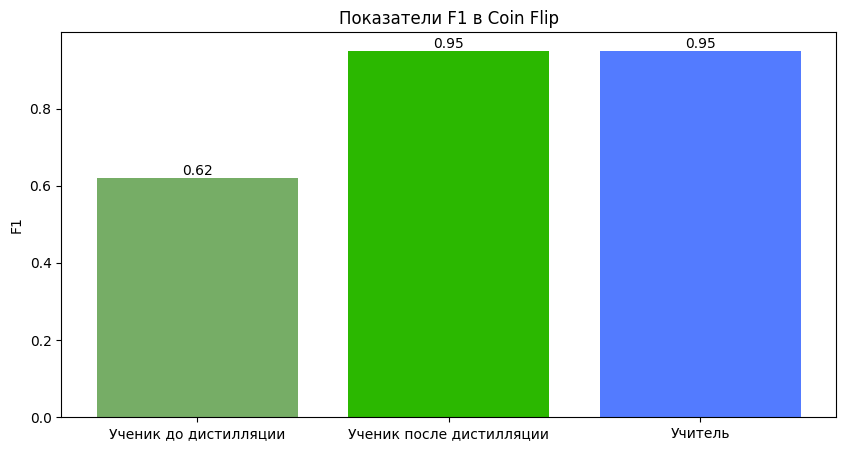

In [15]:
import matplotlib.pyplot as plt

def plot_graph(type, scores):
    fig, ax = plt.subplots(figsize=(10, 5))

    bar_labels = ['Ученик до дистилляции', 'Ученик после дистилляции', 'Учитель']
    colors = ['#76AD66', '#2BB800', '#537BFF']

    bars = ax.bar(bar_labels, scores, width=.8, color=colors)
    ax.bar_label(bars)
    ax.set_ylabel('F1')
    ax.set_title(f'Показатели F1 в {type}')

    plt.show()


plot_graph('Coin Flip', [0.62, 0.95, 0.95])